# World Financial Centers' Venues - Data Cleaning

## Table of Contents

1. [Foursquare gridsearch](#gridsearch)
    
2. [...](#...)

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession, SQLContext, types, Row
from pyspark.sql.functions import isnan, max as F_max, col, struct, row_number, udf
from pyspark.sql.window import Window

from googletrans import Translator

sns.set()

## Compile master dataset
<a id="gridsearch"/>

## Load gridsearch venue datasets with Spark

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("city_venues") \
    .getOrCreate()
spark

In [4]:
# Read city venues datasets compiled from Foursquare API
df = spark.read.csv('data/*_grid_venues.csv', header=True)
df.cache()
df.show(5)

+---+-------+--------------------+--------------+--------------+---------------+---------+
|_c0|   City|               Venue|Venue Category|Venue Latitude|Venue Longitude|Grid Item|
+---+-------+--------------------+--------------+--------------+---------------+---------+
|  0|Jakarta|           Cnooc 114|          null|     -5.454346|     106.349914|        2|
|  1|Jakarta|      Palmindo Barge|          null|     -5.454346|     106.349914|        2|
|  2|Jakarta| Platform rama bravo|          null|     -5.454346|     106.349914|        2|
|  3|Jakarta|Pabelokan gallery...|          null|     -5.454346|     106.349914|        2|
|  4|Jakarta|         Rama Foxrot|          null|      -5.45209|      106.33979|        2|
+---+-------+--------------------+--------------+--------------+---------------+---------+
only showing top 5 rows



In [5]:
# Examine number of venues fetched
df.count()

1583136

## Data cleaning and exploration

In [6]:
# Drop unneeded columns
cities_venues_df = df.drop('_c0').drop('Grid Item')
cities_venues_df

DataFrame[City: string, Venue: string, Venue Category: string, Venue Latitude: string, Venue Longitude: string]

In [7]:
# Drop duplicates

cities_venues_df = cities_venues_df.dropDuplicates()
cities_venues_df.count()

1570724

In [8]:
# Require venues have a name and coordinates

cities_venues_df = cities_venues_df.dropna(subset=['City', 'Venue', 'Venue Latitude', 'Venue Longitude'])
cities_venues_df.count()

1570489

In [9]:
# Replace Venue Category missing values by scanning for other (Venue, Venue Category) pairs

# Show number of missing Venue Category values
cities_venues_df.filter(cities_venues_df['Venue Category'].isNull()).count()

199576

In [10]:
venues_filler_df = cities_venues_df\
                    .drop('City')\
                    .drop('Venue Latitude')\
                    .drop('Venue Longitude')\
                   .filter(cities_venues_df['Venue'].isNull()==False)\
                   .filter(cities_venues_df['Venue Category'].isNull()==False)\
                    .distinct()
venues_filler_df.take(5)

[Row(Venue='Modulo De Licencias Y Control Vehicular', Venue Category='Government Building'),
 Row(Venue='喜多見郵便局', Venue Category='Post Office'),
 Row(Venue='Автостоянка 171', Venue Category='Pier'),
 Row(Venue='Mavi Yaka Restorant', Venue Category='Restaurant'),
 Row(Venue='batak Çiftliği', Venue Category='Farm')]

In [11]:
grouped = (venues_filler_df
           .withColumnRenamed('Venue Category', 'Cat')
           .groupby(['Venue', 'Cat'])
           .count()
           .alias('counts')
          )
grouped.take(5)

[Row(Venue='Westbere Road', Cat='Professional & Other Places', count=1),
 Row(Venue='Boteco do Bigode', Cat='Dive Bar', count=1),
 Row(Venue='Modulo De Licencias Y Control Vehicular', Cat='Government Building', count=1),
 Row(Venue='喜多見郵便局', Cat='Post Office', count=1),
 Row(Venue='Glenfield Station Fast Food and Deli', Cat='Fried Chicken Joint', count=1)]

In [12]:
# Group by Venue, find mode of Venue Category
matcher = (grouped
           .groupBy('Venue')
          .agg(F_max(struct(col('count'),
                           col('Cat'))
                    ).alias('max'))
          .select(col('Venue'), col('max.Cat')))
matcher.cache()
matcher.show(5)

+--------------------+---------------+
|               Venue|            Cat|
+--------------------+---------------+
|"""Результат"" це...|       Building|
|      """Феникс""💅"|     Nail Salon|
|"Bakso sapi & mie...|     Soup Place|
|"Banderillas ""La...|     Food Stand|
|"Biblioteca UAM C...|College Library|
+--------------------+---------------+
only showing top 5 rows



In [13]:
matcher.count()

1225849

In [14]:
cats = cities_venues_df.rdd.map(lambda r: r['Venue Category']).distinct()
cats.take(5)

[None, 'Track', 'Art Studio', 'Taxi', 'Wine Shop']

In [15]:
cats.count()

1021

In [17]:
# Now that  to english before matching (Venue, Venue Category) pairs

# translator = Translator()

# def translate_or_fallback(c):
#     if c and len(c)>0 and c is not 'null':
#         try:
#             t = translator.translate(c)
#             print('t', t)
#             print('translated ' + c + '->' + t.text)
#             return t.text
#         except:
#             print('Could not translate', c)
#     return c

# translated_cols = [translate_or_fallback(c) for c in cats.take(2)]
# translated_cols

Could not translate Track


[None, 'Track']

In [21]:
# translator.translate('안녕하세요.')
# translator.translate?
# translator.translate(['안녕하세요.'])

In [22]:
filled = cities_venues_df.join(matcher, on="Venue", how='left')
filled.cache()
filled.show(10)

+--------------------+-----------+----------------+------------------+------------------+----------------+
|               Venue|       City|  Venue Category|    Venue Latitude|   Venue Longitude|             Cat|
+--------------------+-----------+----------------+------------------+------------------+----------------+
|"""Aneka Baru"" G...|    Jakarta|            null|-6.160815537746671|106.81746610251098|            null|
|"""Anugerah"" Fot...|   Surabaya|            null|         -7.332174|        112.788991|            null|
|"""Результат"" це...|     Almaty|        Building| 43.22220572268064| 76.89824821719338|        Building|
|      """Феникс""💅"|Novosibirsk|      Nail Salon|         55.065008|         82.933895|      Nail Salon|
|"Bakso sapi & mie...|    Jakarta|      Soup Place|-6.259420780857016|106.81567433774006|      Soup Place|
|"Banderillas ""La...|Mexico City|      Food Stand|         19.375896|        -99.052559|      Food Stand|
|"Bengkel Ketok Ma...|   Surabaya|    

In [23]:
@udf("string")
def replace_category(x,y):
    return y if ((not x) | (x == "null")) else x

filled = (filled
     .withColumn('Category', replace_category(filled['Venue Category'], filled.Cat))
     .drop('Venue Category')
     .drop('Cat')
    )
filled.cache()
filled.show(5)

+--------------------+-----------+------------------+------------------+----------+
|               Venue|       City|    Venue Latitude|   Venue Longitude|  Category|
+--------------------+-----------+------------------+------------------+----------+
|"""Aneka Baru"" G...|    Jakarta|-6.160815537746671|106.81746610251098|      null|
|"""Anugerah"" Fot...|   Surabaya|         -7.332174|        112.788991|      null|
|"""Результат"" це...|     Almaty| 43.22220572268064| 76.89824821719338|  Building|
|      """Феникс""💅"|Novosibirsk|         55.065008|         82.933895|Nail Salon|
|"Bakso sapi & mie...|    Jakarta|-6.259420780857016|106.81567433774006|Soup Place|
+--------------------+-----------+------------------+------------------+----------+
only showing top 5 rows



In [93]:
# TODO look at other ways of filling null venue categories - Drop for now

# saturated.drop(saturated['Category'].isNull()).count()
filled = filled.filter(saturated['Category'].isNull()==False)
filled.count()

1385358

In [94]:
# Require cities have Foursquare saturation (at least 50 venues)

saturated = filled.groupby('City').count().sort('count', ascending=False).filter('count>50')
saturated.show(10)

+-----------+-----+
|       City|count|
+-----------+-----+
|    Jakarta|54493|
|    Bangkok|49423|
|Mexico City|41180|
|  São Paulo|32361|
|      Tokyo|28372|
|  Singapore|27717|
|      Izmir|25196|
|     Moscow|23194|
|      Seoul|22822|
|   Istanbul|22474|
+-----------+-----+
only showing top 10 rows



In [95]:
saturated_cities_list = [r.City for r in saturated.collect()]
saturated_cities_list

['Jakarta',
 'Bangkok',
 'Mexico City',
 'São Paulo',
 'Tokyo',
 'Singapore',
 'Izmir',
 'Moscow',
 'Seoul',
 'Istanbul',
 'Antalya',
 'London',
 'Ho Chi Minh City',
 'Konya',
 'Sydney',
 'Fukuoka',
 'Osaka',
 'Rio de Janeiro',
 'Surabaya',
 'Bangalore',
 'Bogotá',
 'Bursa',
 'Shanghai',
 'Manisa',
 'Beijing',
 'Mersin',
 'Balıkesir',
 'New York City',
 'Budapest',
 'Salvador',
 'Saint Petersburg',
 'Mumbai',
 'Cyprus',
 'Medan',
 'Yokohama',
 'Panama',
 'Madrid',
 'Belo Horizonte',
 'Los Angeles',
 'Toronto',
 'Samut Prakan',
 'Rome',
 'Campinas',
 'Incheon',
 'Busan',
 'Kocaeli',
 'Pune',
 'Hatay',
 'Novosibirsk',
 'Daegu',
 'Houston',
 'Fortaleza',
 'Hong Kong',
 'Warsaw',
 'Hanoi',
 'Guadalajara',
 'Manaus',
 'Guangzhou',
 'Hamburg',
 'Dubai',
 'Chennai',
 'Monterrey',
 'Taipei',
 'Adana',
 'Querétaro',
 'Paris',
 'Ekaterinburg',
 'Chicago',
 'Praha',
 'Gaziantep',
 'Auckland',
 'Nagoya',
 'Buenos Aires',
 'Kyoto',
 'Prague',
 'Wien',
 'Sanliurfa',
 'Bucharest',
 'Shenzhen',
 'Phoe

In [96]:
len(saturated_cities_list)

250

In [97]:
saturated = filled.filter(col("City").isin(saturated_cities_list))
saturated.count()

1385042

## Explore compiled dataset

In [98]:
# Explore cities
cities = saturated.groupby('City').count()
cities.cache()
sorted_cities = cities.sort('count', ascending=False)
sorted_cities.show(10)

+-----------+-----+
|       City|count|
+-----------+-----+
|    Jakarta|54493|
|    Bangkok|49423|
|Mexico City|41180|
|  São Paulo|32361|
|      Tokyo|28372|
|  Singapore|27717|
|      Izmir|25196|
|     Moscow|23194|
|      Seoul|22822|
|   Istanbul|22474|
+-----------+-----+
only showing top 10 rows



In [99]:
sorted_cities.count()

250

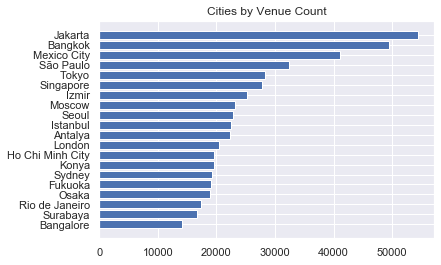

In [100]:
top_cities = [(c.City,c['count']) for c in sorted_cities.take(20)]
x,y = zip(*top_cities)
plt.barh(x,y)
plt.title('Cities by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [101]:
categories = saturated.groupby('Category').count()
sorted_categories = categories.sort('count', ascending=False)
sorted_categories.show(10)

+--------------------+-----+
|            Category|count|
+--------------------+-----+
|              Office|51893|
|Residential Build...|45928|
|            Building|30999|
|                Café|27639|
|                Road|24897|
|  Salon / Barbershop|22347|
|             Factory|21742|
| Housing Development|18938|
|   Convenience Store|17195|
|                Bank|16822|
+--------------------+-----+
only showing top 10 rows



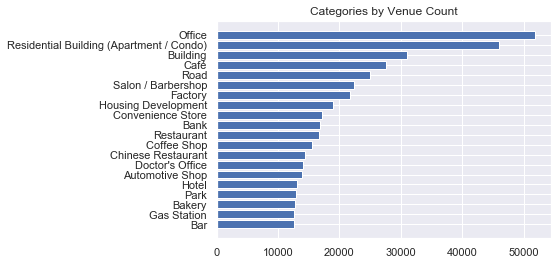

In [102]:
top_categories = [(str(c.Category),c['count']) for c in sorted_categories.take(20)]
x,y = zip(*top_categories)
plt.barh(x,y)
plt.title('Categories by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [103]:
venues = saturated.groupby('Venue').count().sort('count', ascending=False).cache()
venues.show(10)

+------------------+-----+
|             Venue|count|
+------------------+-----+
|        McDonald's| 1083|
|          7-Eleven|  964|
|         Starbucks|  890|
|            Subway|  884|
|             Shell|  784|
|Starbucks (星巴克)|  661|
|     HDFC Bank ATM|  636|
|    Domino's Pizza|  507|
|               KFC|  492|
|         Pizza Hut|  475|
+------------------+-----+
only showing top 10 rows



In [104]:
venues.count()

1225575

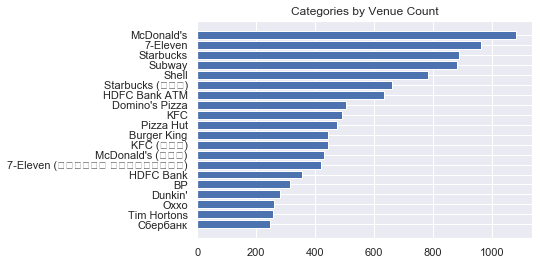

In [105]:
top_venues = [(str(c.Venue),c['count']) for c in venues.take(20)]
x,y = zip(*top_venues)
plt.barh(x,y)
plt.title('Categories by Venue Count')
plt.gca().invert_yaxis()
plt.show()

In [66]:
# TODO: Clean Venues list to match Starbucks(blahblah) to Starbucks

## Save Count and Frequency outputs

In [106]:
saturated.show(5)

+--------------------+-----------+------------------+------------------+---------------+
|               Venue|       City|    Venue Latitude|   Venue Longitude|       Category|
+--------------------+-----------+------------------+------------------+---------------+
|"""Результат"" це...|     Almaty| 43.22220572268064| 76.89824821719338|       Building|
|      """Феникс""💅"|Novosibirsk|         55.065008|         82.933895|     Nail Salon|
|"Bakso sapi & mie...|    Jakarta|-6.259420780857016|106.81567433774006|     Soup Place|
|"Banderillas ""La...|Mexico City|         19.375896|        -99.052559|     Food Stand|
|"Biblioteca UAM C...|Mexico City|19.351818364557786|-99.28326962978603|College Library|
+--------------------+-----------+------------------+------------------+---------------+
only showing top 5 rows



In [107]:
counted_venues = saturated.groupBy("City").pivot("Category").count()
counted_venues.count()

250

In [108]:
counted_df = counted_venues.toPandas()
counted_df

,City,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tangerang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cairo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Phoenix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Munich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,Bogotá,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,Makasar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,Izmir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,9.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [109]:
counted_df.to_csv('data/counted_world_venues.csv')
# counted_df = pd.read_csv('data/counted_world_venues.csv', index_col=0)
counted_df

,City,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
0,Bangalore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tangerang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cairo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Phoenix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Munich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,Bogotá,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,Makasar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,Izmir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,9.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN


### Convert neighborhood venue type counts to frequencies

In [112]:
counted_df.set_index('City', drop=True, inplace=True)

venue_frequency = counted_df.fillna(0).div(counted_df.sum(axis=1), axis=0)
venue_frequency

,"Богданов и партнеры""""""","""""dakineshop.ru""""""","117""""""","12""""""","13""""""","17""""""","18""""""","18.""","34""""""","38""""""",...,Zhejiang Restaurant,Zoo,Zoo Exhibit,"quando e dove vuoi tu """"""",Çöp Şiş Place,"Корпорация СБР""","д.24""""""","не Дай Другим""""""","площадка #2""","студия звукозаписи."""
City,,,,,,,,,,,,,,,,,,,,,
Bangalore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000071,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Tangerang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Casablanca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000322,0.000322,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Cairo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Phoenix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000539,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Munich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Bogotá,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000144,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Makasar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [113]:
venue_frequency.to_csv('data/world_venues_frequency.csv')